<a href="https://colab.research.google.com/github/tuanaasuokturk/MBC_data_analysis/blob/main/Assignment_7_ipynb_Tuana_Asu_Okturk.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1 style="font-size: 2.5em; font-weight: bold; margin-top: 0.5em; margin-bottom: 0.5em;">
 Assignment 7: the Drift-Diffusion Model</h1>

In this assignment, we will study how the Drift-Diffusion Model to capture choices and reaction times in (speeded) decision-making tasks. We will :
- **simulate** the drift-diffusion model to understand the impact of its parameters on the pattern of choices and reaction times
- **fit** the drift-diffusion model to behavioral data from monkeys performing a motion discrimination task

You can prepare for the assignment by reading the following review: Ratcliff, Smith et al., *Trends in Cognitive Sciences*, 2016 ([pdf](https://bpb-us-w2.wpmucdn.com/u.osu.edu/dist/6/60429/files/2018/09/trends16-1p31ugz.pdf))

If running through Google Colab, uncomment and run the cell below to install pyddm. If running locally, install pyddm with the following command `pip install pyddm` (e.g. in Acaconda Prompt).

In [40]:
!pip -q install pyddm

In [41]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pyddm
import pyddm.plot

# Simulating the drift-diffusion model by hand
We're going to simulate the drift-diffusion model in a variety of conditions and study of patterns of reaction times and responses that it produces, to develop some intutions on how the different parameters impact the behavior produced. The idea is to learning how the DDM works, but in practice, it is better to use an optimised library for simulating DDMs in your research.  In the following parts, we will learn to use one such library.

## Writing a function to simulate the DDM
**Complete the code the below** that runs a single simulation of the DDM. DDM parameters (drift rate, noise variance, bounds) are provided as arguments.
We provided two different options: either with a loop that updates the decision variable at every time step (Option 1), or directly using operations over arrays (Option 2). Choose whichever you prefer.

In [42]:
# Option 1: loop through time
def run_ddm(drift_rate=.6, noise=1, bound=1.4, dt=.01, T_dur=4):
    """
    Simulate single run of discrete DDM (stores trajectory of decision variable)

    [X, side, RT] = run_ddm(v, a, z, dt)

    Input:
        drift_rate: drift rate
        noise: standard deviation of noise
        bound: the threshold(lower boundary corresponds to -a, upper boundary to a)
        dt: time step for discretized version of dynamics
        T_dur: total runtime, in seconds

    Output:
        X: vector with dynamics of the decision variable until hitting the boundary
        side: +1 if DV hits the upper boundary, -1 if DV hits the lower boundary
        RT: reaction time

    """

    tmax = int(T_dur/dt);   # maximum number of time steps

    # Initialize decision variable x to 0
    x = 0

    # Vector of all values of DV
    X = [x]

    # Looping through time
    for t in range(tmax):
        # discrete DDM equation: update of decision variable
        x += drift_rate*dt + np.sqrt(dt) * noise * np.random.randn()

        X.append(x) # append x to vector of DV

        # check boundary conditions
        if x < -bound:
            side = -1
            break
        if x > bound:
            side = 1
            break
    else: # executed if no break has occurred in the for loop
        # If no boundary is hit before maximum time,
        # choose according to decision variable value
        side = 1 if x > 0 else -1

    rt = t*dt
    return X, side, rt

# Option 2: the vectorized four-line version
def run_ddm(drift_rate=.6, noise=1, bound=1.4, dt=.01, T_dur=4):
    # Run the actual trajectory
    trajectory = np.cumsum(drift_rate*dt + noise*np.sqrt(dt)*np.random.randn(int(T_dur/dt)))
    # Find the first place where it crosses the upper or lower bound.  If there
    # was no bound crossing, consider the RT to be the end time (forcing a
    # choice).
    RT_index = min(np.where(np.abs(trajectory)>bound)[0], default=len(trajectory)-1)
    # Calculate the RT from the bound crossing
    RT = RT_index * dt
    # Check whether it is the upper or lower bound we crossed.  This also
    # handles the case where the trial didn't terminate, i.e., where RT_index
    # is the last element in the trajectory, by taking the bound it was closest
    # to.
    choice = int(trajectory[RT_index] > 0)
    return trajectory[0:RT_index], choice, RT



Once you have written this function, use it simulate 5 trials and plot dynamics of the decision variable and bounds
Use parameter values: drift = 0.5, bound = 1.2, and no non-decision-time.
Use time step dt = 0.001 and a duration of 4 sec.

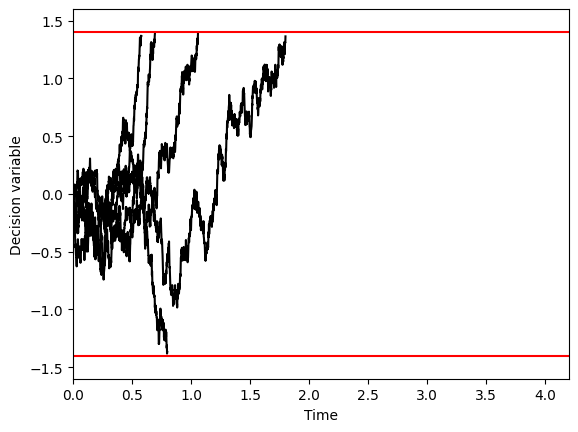

In [43]:
bound = 1.4
noise = 1
drift_rate = .6
T_dur = 4
dt = .001
for i_trial in range(5): # for each trial
    X, _, _ = run_ddm(drift_rate=drift_rate,
                       noise=noise,
                       bound=bound,
                       dt=dt,
                       T_dur=T_dur) # simulate my DDM
    plt.plot(dt*np.arange(0, len(X)), X, c='k')

plt.xlabel('Time');
plt.ylabel('Decision variable');
plt.ylim((-bound-.2, bound+.2));
plt.xlim(0, T_dur+.2);

# adding red horizontal lines at plus/minus bound to delineate the decision boundaries
plt.axhline(bound, c='r');
plt.axhline(-bound, c='r');

Repeat with 500 trials.  Add transparency of 0.01 to the lines so that you can still see the density.

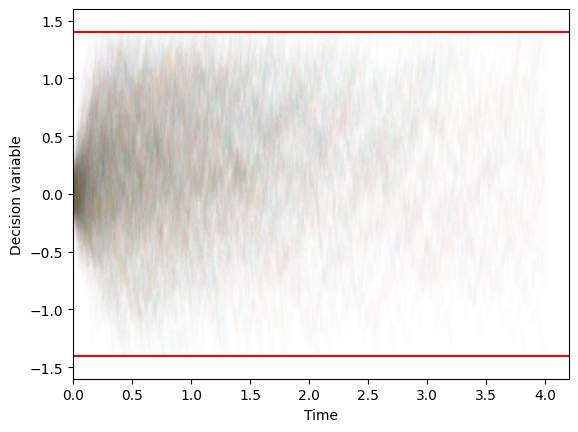

In [44]:
for i_trial in range(500): # for each trial
    X, __, _ = run_ddm(drift_rate=drift_rate,
                       noise=noise,
                       bound=bound,
                       dt=dt,
                       T_dur=T_dur)
    plt.plot(dt*np.arange(0, len(X)), X, alpha=.01)

plt.xlabel('Time');
plt.ylabel('Decision variable');
plt.ylim((-bound-.2, bound+.2));
plt.xlim((0, T_dur+.2));
plt.axhline(bound, c='r');
plt.axhline(-bound, c='r');

Notice with transparency that you can see the density of particles which hit a given point.  We will come back to this in Part 2.

## Plot the RT distribution
**Run the DDM 10000 times.**  The actual trajectories are unobserved, the only thing we can compare to behavior is the choice that was made and the reaction time  (i.e. which boundary was hit, and when). Plot a histogram, separately for correct and incorrect responses.
Use parameters: drift = 0.6, bound = 1.4, noise = 1, dt=.005, T_dur = 4.  Also include a non-decision time of 0.3 s.

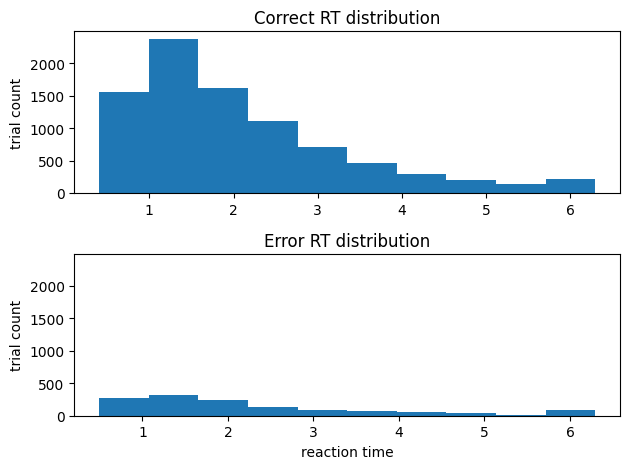

In [45]:
N_trials = 10000
drift_rate = .5
bound = 1.2
noise = .8
dt = .005
T_dur = 6
non_decision_time = .3

correct_rts = []
error_rts = []
for i in range(0, N_trials):
    # run DDM for this trial
    _, resp, rt = run_ddm(drift_rate=drift_rate,
                          noise=noise,
                          bound=bound,
                          dt=dt,
                          T_dur=T_dur)


    #add non decision-time
    rt = rt + non_decision_time

    # add value to corresponding array
    if resp > 0:
        correct_rts.append(rt)
    else:
        error_rts.append(rt)

ax1 = plt.subplot(2,1,1)
plt.hist(correct_rts)
plt.title("Correct RT distribution")
plt.ylabel("trial count");
plt.subplot(2,1,2, sharey=ax1)
plt.hist(error_rts)
plt.title("Error RT distribution");
plt.ylabel("trial count");
plt.xlabel("reaction time");
plt.tight_layout()

# Simulating the drift-diffusion model with PyDDM
In practice, we generally want to perform simulations with a dedicated library instead of by hand.  This is because there are more efficient solutions than simulating individual trajectories. For instance, many DDMs have closed-form mathematical expressions for the RT distribution, so we don't need to simulate individual trajectories. For models that don't have closed-form solutions, simulators are still able to simulate much faster by simulating the entire probability distribution of evolving particle density instead of individual decisions one by one.  This also allows you to have a continuous estimate of the probability density function, instead of a histogram of responses.  In addition to being visually cleaner, it allows fitting the model using maximum likelihood.

You may find it useful in this section and later sections to consult the [PyDDM documentation](https://pyddm.readthedocs.io/en/latest/), especially the [cookbook](https://pyddm.readthedocs.io/en/latest/cookbook/index.html), the [quick start guide](https://pyddm.readthedocs.io/en/latest/quickstart.html), and the [API documentation](https://pyddm.readthedocs.io/en/latest/apidoc/model.html).

## Simulating the DDM with PPDM
**Simulate 10000 trials of the drift-diffusion model with PyDDM and plot the RT distribution**
Hint: You will want to create a PyDDM model using the "gddm" function, solve it, and then use the "sample" function on the solution.

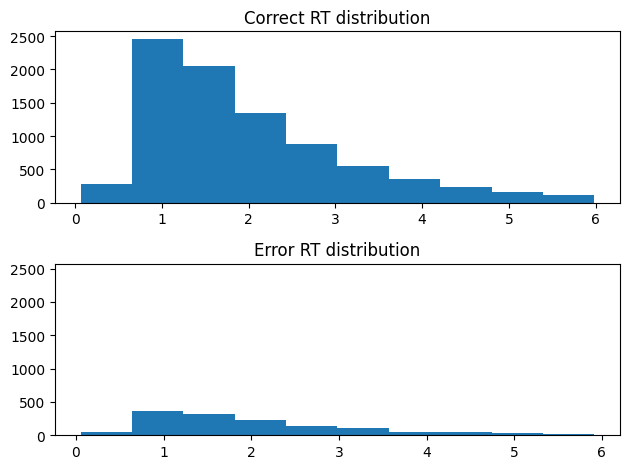

In [46]:
import pyddm
N_trials = 10000

# create model with specific parameters (values have been set in previous section)
m = pyddm.gddm(drift=drift_rate, noise=noise, bound=bound, nondecision=non_decision_time, T_dur=T_dur)

# compute choice and RT densities
sol = m.solve()

# simulate 10.000 trials with given choice and RT densities
sample = sol.sample(N_trials)

# extract RTs for correct and incorrect responses
correct_rts = sample.choice_upper
error_rts = sample.choice_lower

ax1 = plt.subplot(2,1,1)
plt.hist(correct_rts)
plt.title("Correct RT distribution")
plt.subplot(2,1,2, sharey=ax1)
plt.hist(error_rts)
plt.title("Error RT distribution")
plt.tight_layout()

## Computing the RT density function with PyDDM
PyDDM allows to recover the full density functions for RT and choices, which would amount to simulating an infinite number of trials. Hint: Every "solution" object contains the full RT distribution as pdf("correct") and pdf("error"), so this should require fewer lines of code than (a)

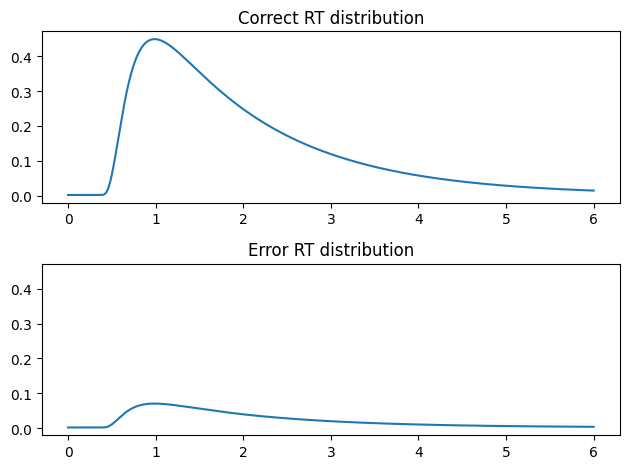

In [47]:
# create model with given parameters and compute RT densities
m = pyddm.gddm(drift=drift_rate, noise=noise, bound=bound, nondecision=non_decision_time, T_dur=T_dur)
sol = m.solve()

# here we access directly the pdf for correct and error RTs
correct_pdf = sol.pdf("correct")
error_pdf = sol.pdf("error")

# now plot them in different subplots
ax1 = plt.subplot(2,1,1)
plt.plot(m.t_domain(), correct_pdf)
plt.title("Correct RT distribution")
plt.subplot(2,1,2, sharey=ax1)
plt.plot(m.t_domain(), error_pdf)
plt.title("Error RT distribution")
plt.tight_layout()

## Explore how RT density and choices depend on DDM parameters
The following code allows to explore how the densities for correct and error responses depend on the DDM parameters.

Note: The strings `"d"`, `"n"` and `"b"` are placeholders for a value which has not yet been fit to data.  There is nothing special about the strings "d" and "n", we could have used `"drift"` , `"noise"` and `"bound"`, `"param1"`,`"param2"` and `"param3"`; or any other strings.  All we need to do is specify the valid ranges for these parameters in the "parameters" argument to the "gddm" function.  In this case, we let the drift vary from -2 to 2, and the noise vary from .1 to 1.5. We will see this pattern coming up again and again.

Note: Make sure the "real-time" checkbox is checked once the model gui starts in order to update the plot as you drag the sliders

Another note: If you are running this notebook locally instead of on Google Colab, you can also run `"model_gui"` in addition to `model_gui_jupyter` to run the interface in a pop-up window instead of in the Jupyter notebook.

In [48]:
from pyddm.plot import model_gui_jupyter
m = pyddm.gddm(drift="d", noise="n", bound="b", parameters={"d": (-2, 2), "n": (.1, 1.5), "b": (.1, 3)}, T_dur=4, dt=.001)
model_gui_jupyter(m)

Output()

**Do take 5 minutes to play with parameters, watch their impact on the densities, and reflect on why each parameter impacts behavior in their specific way.**

# Fitting the drift-diffusion model

We now turn to the juicier part of the tutorial: let's see how we can fit the DDM to actual behavioral data and interpret the results.

## Fit a simple DDM for a single subject
We will fit the DDM to a non-human primate subject from [Roitman and Shadlen (2002)](https://www.jneurosci.org/content/22/21/9475) performing the random dot motion task.

[Download data](https://pyddm.readthedocs.io/en/latest/_downloads/bcc1102d5b69c49dac52b49536b87240/roitman_rts.csv)

Let's first download the data as a dataframe and inspect it. We see the value of motion coherence in `coh`, the choice (left/right) in `trgchoice`, its accuracy in `correct` and the reaction time (in seconds) in `rt`.

In [49]:
import pyddm
import pyddm.plot
import pandas

#First, load the data we wish to use
df = pandas.read_csv("https://raw.githubusercontent.com/mwshinn/PyDDM/master/doc/downloads/roitman_rts.csv")

# We select data from monkey 1 only
df = df[df["monkey"] == 1]

df.trgchoice = df.trgchoice-1 # convert to 0:left, 1:right

#adding stim category and signed coherence (needed for biased DDM)
df['stim_category'] = df.trgchoice*df.correct + (1-df.trgchoice)*(1-df.correct) # 0 if leftward stimulus, 1 if rightward
df['signed_coh'] = df.coh * np.sign(df.stim_category-.5) # positive if rightward motion, negative if leftward

df.head()

,monkey,rt,coh,correct,trgchoice,stim_category,signed_coh
0,1,0.355,0.512,1.0,1.0,1.0,0.512
1,1,0.359,0.256,1.0,0.0,0.0,-0.256
2,1,0.525,0.128,1.0,0.0,0.0,-0.128
3,1,0.332,0.512,1.0,0.0,0.0,-0.512
4,1,0.302,0.032,0.0,1.0,0.0,-0.032


We need to pass this data to `PyDDM`. This is done using `from_pandas_dataframe`, where we specify which variable in the data frame corresponds to binary choices and which one corresponds to reaction times.

In [50]:
sample = pyddm.Sample.from_pandas_dataframe(df, rt_column_name="rt", choice_column_name="correct")

Let's first **fit a model that ignores the coherence** and assumes the same DDM parameters for all trials.  It is probably not going to be a very good model, but it will show us how to fit a model in PyDDM.  **Adjust the parameters manually to capture RT densities.**

In [51]:
m_basic = pyddm.gddm(drift="drift", bound="bound", nondecision="nd",
               parameters={"drift": (-2, 2), "bound": (.5, 3), "nd": (0, .5)})
pyddm.plot.model_gui_jupyter(model=m_basic, sample=sample)

Output()

Now **perform the fit**. Here we pass on the dataset in argument `sample`.

In [52]:
m_basic.fit(sample=sample, verbose=False)

Info: Params [1.11816034 0.66473363 0.30999033] gave 910.9436805089107
Info:pyddm:Params [1.11816034 0.66473363 0.30999033] gave 910.9436805089107


Show information about the fit. Here you can see the estimated value for each parameter as well as the negative Log-Likelihood (used as a loss function)

In [53]:
m_basic.show()

Model nd information:
Choices: 'correct' (upper boundary), 'error' (lower boundary)
Drift component DriftConstant:
    constant
    Fitted parameters:
    - drift: 1.118160
Noise component NoiseConstant:
    constant
    Fixed parameters:
    - noise: 1.000000
Bound component BoundConstant:
    constant
    Fitted parameters:
    - B: 0.664734
IC component ICPointRatio:
    An arbitrary starting point expressed as a proportion of the distance between the bounds.
    Fixed parameters:
    - x0: 0.000000
Overlay component OverlayChain:
    Overlay component OverlayNonDecision:
        Add a non-decision by shifting the histogram
        Fitted parameters:
        - nondectime: 0.309990
    Overlay component OverlayMixtureEasy:
        easy_mixture_model
        (No parameters)
Fit information:
    Loss function: Negative log likelihood
    Loss function value: 910.9436805089107
    Fitting method: differential_evolution
    Solver: auto
    Other properties:
        - nparams: 3
        

**How do the manually fitted parameters compare to maximum likelihood estimates?**

Drift rate: manually you set ≈ –1.3, whereas ML finds ≈ +1.12. The absolute magnitude is similar, so both fits imply a fairly strong drift. The sign flip just reflects how “correct” vs “error” is coded in the model/data; it doesn’t change the qualitative interpretation that evidence accumulates quickly toward one bound.

Boundary separation (B): manually ≈ 0.7, ML ≈ 0.66. So the ML fit only slightly shrinks the distance between bounds to better match the speed/accuracy trade-off.

Non-decision time (nd): manually ≈ 0.30 s, ML ≈ 0.31 s, essentially identical. Your manual tuning already captured the leading edge of the RT distribution well.

So, the manual fit gives a reasonable approximate description of the data, while the ML fit fine-tunes the values (especially the combination of drift and bound) to maximize likelihood in a principled, quantitative way.

We can also use the model gui again, but this time, to visualise the fit that we just performed.

In [54]:
pyddm.plot.model_gui_jupyter(model=m_basic, sample=sample)

Output()

**How good it the fit? How do reaction times in correct and incorrect trials compare in the data? What about in the model? Was this expected?**

The fit is pretty good overall.
In the top panel, the black curve for correct trials follows the grey empirical histogram quite closely: it picks up the sharp rise around ~0.3–0.4 s, the location of the peak, and the long right tail. There may be some small mismatch in the far tail (where there are few trials anyway), but the main mass of the distribution is well captured.
For the error trials, the empirical histogram is noisier (there are fewer errors), but the model’s error-RT density has roughly the same peak time and spread: a low density at very short RTs, a maximum a bit later, then a gradual decay. So the model reproduces the qualitative shape, even if the match is not as visually tight as for correct trials.
Regarding RT differences:


In the data, correct trials tend to be faster on average than incorrect trials: the bulk of the grey mass for corrects is earlier in time, while error RTs are more spread out and shifted slightly later.


In the model, the same pattern appears: the correct-RT density peaks earlier and more sharply; the error-RT density is lower, broader, and shifted to longer times.


Yes, this pattern is expected from a DDM with a positive drift toward the “correct” boundary. Because the drift pulls the decision variable toward the correct bound, it tends to hit that bound quickly and often → many fast correct responses. Errors mostly arise when noise temporarily overwhelms the drift and pushes the state to the wrong bound, which typically takes longer on average → fewer, slower errors. The fitted parameters just make this qualitative prediction line up quantitatively with the monkey’s RT distributions.

## Fitting a coherence-dependent DDM to a single subject

The model above is ignoring that the motion coherence of the randot dot kinetogram changes from trial to trial. However we're pretty sure that this should impact the behavior.  Let's improve this model!  So, we need our drift rate to depend on the coherence of the stimulus in each trial.  In the data provided, the coherence is saved as the column `coh`.

In PyDDM, `"coh"` is called a `"condition"` because it describes some property of the underlying trial.  In addition to depending on parameters, models may also depend on conditions.

To implement a drift rate that depends on coherence, we must define the drift rate as a function.  Functions can be used to define any of the DDM parameters. They may take ***conditions** and **parameters** as arguments.  

So, to incorporate coherence into the model, we must create a function which takes `"coh"` as an argument, as well as a scaling factor for the coherence (a parameter that we will call the *drift scale*), and output the corresponding drift for this trial.
**Complete the function below** that takes the motion coherence (condition), the drift scale (parameter) and outputs the drift of the DDM for the corresponding trial.

In [55]:
# complete the function below
def drift_coherence(coh, drift_scale):
    return coh * drift_scale

Note: in the future, for simplicity, we will make use of "lambda function" notation (also called "anonymous functions") to define function parameters.  This notation is shorter but equivalent!

In [56]:
# Here is the notation for lambda functions.
drift_coherence = lambda coh,drift_scale: coh*drift_scale

Now, we can construct the final model and fit it to data.  Create a model that uses your new drift function and visualise it with your sample using `pyddm.plot.model_gui_jupyter`.
Here you can appreciate the new know which allows you to plot the data for the entire dataset, or selecting one specific value of coherence.

In [57]:
# Here is the notation for lambda functions.
drift_coherence = lambda coh, drift_scale: coh * drift_scale

m_coh = pyddm.gddm(drift=drift_coherence, bound="bound", nondecision="nd",
                   parameters={"drift_scale": (-20, 20), "bound": (.1, 3), "nd": (0, .5)},
                   conditions=["coh"])

pyddm.plot.model_gui_jupyter(model=m_coh, sample=sample)

Output()

Now, fit your model to data.

In [58]:
m_coh.fit(sample=sample, verbose=False)

Info: Params [10.25596074  0.75304305  0.30808176] gave 222.35087923927844
Info:pyddm:Params [10.25596074  0.75304305  0.30808176] gave 222.35087923927844


And visualize the fitted model:

In [59]:
pyddm.plot.model_gui_jupyter(model=m_coh, sample=sample)

Output()

**Interpret**

Allowing drift to depend on coherence lets the DDM explain not just overall speed and accuracy, but also how the entire RT distribution arises from a mix of easy and hard trials, and the fitted curves show that this coherence-dependent model matches the monkey’s behavior substantially better than the coherence-ignoring model.

## Validating the model: plotting the psychometric and chronometric curves
**It is fundamental to check that the model captures now just the raw distributions of reaction times, but how accuracy and reaction times depend on experimental conditions.** This is done by comparing the psychometric and chronometric curves for model vs. data. The psychometric curve shows the coherence/evidence on the x axis and the probability of a correct response on the y axis.  Likewise, the chronometric curve shows the coherence/evidence on the x axis and the mean RT of correct responses on the y axis.
PyDDM has a function built-in for visualizing psychometric and chronometric functions in the model GUI.
The experimental data is shown with error bars, the model correspond to full lines.

In [60]:
pyddm.plot.model_gui_jupyter(model=m_coh, sample=sample, plot=pyddm.plot.plot_psychometric('coh'))

Output()

The chronometric function:

In [61]:
pyddm.plot.model_gui_jupyter(model=m_coh, sample=sample, plot=pyddm.plot.plot_chronometric('coh'))

Output()

## More flexible modelling with contaminants/lapses
What happens if the subject responds during the non-decision time?  The model predicts no responses, so in theory, the model should give a likelihood of zero.  (Do you understand why?) Hence, since the log of zero is negative infinity, we will have a negative log likelihood of infinity.  (More generally, if there is even one "outlier" response at a time when the model predicts there should be none, this will have a large effect on the model.)  But when you look at our data, there are indeed a few responses during the non-decision time.  So why is the likelihood finite?

It is finite because we have been cheating a bit.  By default, PyDDM returns a mixture model.  We assume that X% of trials are generated by the DDM, and (100-X)% of trials are generated by some other process, for example, an evidence-independent probability distribution.  By default, PyDDM assumes 2% of trials are drawn from a uniform distribution.  This can be changed by using the `"mixture_coef"` argument to the "gddm" function - we can even fit this parameter to data!

Below, modify our model to use an error distribution with a uniform distribution.  Use a fittable mixture ratio.

In [62]:
m_contaminant = pyddm.gddm(drift=drift_coherence, bound="b", nondecision="nd", mixture_coef="mix",
               parameters={"drift_scale": (-20, 20), "b": (.1, 3), "nd": (0, .5), "mix": (.01, .5)},
               conditions=["coh"])


pyddm.plot.model_gui_jupyter(model=m_contaminant, sample=sample)

Output()

In [63]:
m_contaminant.fit(sample=sample, verbose=False)

Info: Params [1.02321800e+01 7.52168512e-01 3.05951039e-01 1.00000000e-02] gave 214.28898520669458
Info:pyddm:Params [1.02321800e+01 7.52168512e-01 3.05951039e-01 1.00000000e-02] gave 214.28898520669458


In [64]:
pyddm.plot.model_gui_jupyter(model=m_contaminant, sample=sample)

Output()

# Generalized drift-diffusion models
Generalized drift-diffusion models (GDDMs) allow going beyond the standard model parameters of the DDM.  Instead of drift, noise, and bound being fixed values, GDDMs allow them to be functions which may vary across time.  For example, this allows modelling tasks which have evidence that changes over time.  It also allows these to have complex, non-linear relationships with any number of task conditions and use any number of parameters.  For example, it is possible to model multisensory integration, with different streams of evidence contributing non-linearly to drift rate.  Furthermore, it also allows integration to be leaky (i.e. forgetting) or unstable (i.e. biasing early evidence), as well as representing an urgency signal (e.g. bounds which collapse over time).  There is evidence that these model properties are useful for modelling RTs in overtrained human or animal subjects.

## Collapsing boundaries
Sometimes, especially in the case of overtrained animals, more evidence may be needed to make a decision earlier in the trial compared to later in the trial.  **Construct, visualize, and fit a model with exponentially-boundaries** to the random dot dataset. Now the decision boundaries depend on two parameters: the initial value (`"bound"`) and the time scale at which the boundaries collapse (`"collapse_time_scale"`). It might be a bit slower when you call model.fit() since this model cannot be solved analytically.

To do this, you can use the magic argument `"t"` to the boundary function, representing the current time in the trial.

## Collapsing boundaries

In [65]:
# create the function for collapsing boundaries, where the decision boundaries fall exponentially with time
collapsing_bound_fun = lambda t, bound, collapse_time_scale: bound * np.exp(-t / collapse_time_scale)
m_collapsing = pyddm.gddm(drift=drift_coherence,
                          bound=collapsing_bound_fun,
                          nondecision="ndt",
                          parameters={"drift_scale": (-20, 20),
                                      "bound": (.1, 3),
                                      "collapse_time_scale": (.01, 3),
                                      "ndt": (0, .5)},
                          conditions=["coh"])

pyddm.plot.model_gui_jupyter(model=m_collapsing, sample=sample)

Output()

In [69]:
m_collapsing.fit(sample=sample, verbose=False)

Info: Params [9.71842342 2.29660608 0.4772904  0.17865627] gave -304.60640614244926
Info:pyddm:Params [9.71842342 2.29660608 0.4772904  0.17865627] gave -304.60640614244926


In [70]:
pyddm.plot.model_gui_jupyter(model=m_collapsing, sample=sample)

Output()

**Interpret**

Early in the trial the monkey behaves as if it uses a strict criterion (high bound) – it rarely makes very fast decisions unless the evidence is very strong.

As time passes, the effective criterion relaxes (bounds collapse), so the animal is increasingly willing to respond with less accumulated evidence. That produces more decisions around ~0.5–0.8 s and helps capture the long right tail.

Compared to the fixed-bound coherence model, this collapsing-bound model builds in an urgency signal and uses a shorter non-decision time, while still using coherence-scaled drift to explain why higher coherence yields more accurate and faster responses.

So: the plot shows that a DDM with coherence-dependent drift and collapsing bounds can capture the main features of the monkey’s RT distribution while embodying a plausible “urgency to decide” over time.

## Side bias

It is frequent that participant display some bias towards one side. Sometimes it's just an idiosyncratic bias, or sometimes it can be informed by the recent history of stimuli, choices and outcomes, as participants adapt to their environment.
Here we will capture this bias by allowing the decision variable to be initalized closer to one bound than the other.
In our dataset, we also have information about which side the monkey chose to get the correct answer ("trgchoice" in the Roitman dataset, which has values "1" or "2").  Let's use a GDDM to implement a side bias.

**Note:** Until now we have taken correct and incorrect choices for the two possible options. Of course this does not mean that the decision boundaries that the perceptual system actually uses correspond to correct and incorrect responses, because the perceptual system does not have access to this information in the first place. The boundaries for that the perceptual system actually use are for left and right responses, and the idea is that the drift term will be towards the left boundary for left stimulus and towards the right boundary for right stimulus, and if everything is symmetric we can lump everything together and see that the drift is always positive towards the correct choice.
Now that we actually include some asymmetry in the system (with this lateralized starting point of the decision variable), we will recode everything using left for one bounary and right for the other one.

First, we generate a novel "sample" object where the choice is taken from `trgchoice` (0 if left, 1 if right).

In [71]:
sample_sided = pyddm.Sample.from_pandas_dataframe(df, rt_column_name="rt", choice_column_name="trgchoice")

Now we introduce our variant of the DDM where the starting_position is a parameter (between -1 and 1, where 0 is no bias and positive numbers indicate a bias towards the rightward bound).


In [72]:
m_bias = pyddm.gddm(drift= lambda signed_coh,drift_scale: signed_coh*drift_scale,
               bound="bound",
               starting_position="x0",
               nondecision="ndt",
               parameters={"drift_scale": (-20,20), "bound": (.1, 3), "x0": (-.8, .8), "ndt": (0, .5)},
               conditions=["signed_coh"])

pyddm.plot.model_gui_jupyter(model=m_bias, sample=sample_sided)

Output()

Even though the ylabels say "error RTs" and "correct RTs", we are actually plotting the RT densities for leftward and rightward choices separately. You can check this better by selecting only trials with leftward motion (i.e. -0.512).

In [73]:
m_bias.fit(sample=sample_sided, verbose=False)

Info: Params [10.5424429   0.74999964  0.07970348  0.31057376] gave 200.32597780055534
Info:pyddm:Params [10.5424429   0.74999964  0.07970348  0.31057376] gave 200.32597780055534


We can check below that the bias is really weak.

Note: an alternative way of introducing a bias would be in the drift rate, where the drift would have a constant positive or negative value on top of the motion-dependent drift.

In [74]:
m_bias.show()

Model ndt information:
Choices: 'correct' (upper boundary), 'error' (lower boundary)
Drift component DriftEasy:
    easy_drift
    Fitted parameters:
    - drift_scale: 10.542443
Noise component NoiseConstant:
    constant
    Fixed parameters:
    - noise: 1.000000
Bound component BoundConstant:
    constant
    Fitted parameters:
    - B: 0.750000
IC component ICPointRatio:
    An arbitrary starting point expressed as a proportion of the distance between the bounds.
    Fitted parameters:
    - x0: 0.079703
Overlay component OverlayChain:
    Overlay component OverlayNonDecision:
        Add a non-decision by shifting the histogram
        Fitted parameters:
        - nondectime: 0.310574
    Overlay component OverlayMixtureEasy:
        easy_mixture_model
        (No parameters)
Fit information:
    Loss function: Negative log likelihood
    Loss function value: 200.32597780055534
    Fitting method: differential_evolution
    Solver: auto
    Other properties:
        - nparams: 4


# Model selection in DDMs
We can select the model that best accounts for this subject data by running model selection. Here we will do it using the Bayesian Information Criterion. As for all modelling packages, `PyDDM` provides the maximum likelihood value after fitting, as well as the other metrics (number of observations= trials, numbers of parameters) needed to compute the BIC. **Complete the code below to compute the BIC for the plain DDM** (that does not depend on coherence)

In [76]:
# retrieve log-likelihood, sample size and number of parameters from fitted object
LLH = -m_basic.fitresult.value() # value is the loss function which is negative LLH
SampleSize = m_basic.fitresult.properties['samplesize']
nParams = m_basic.fitresult.properties['nparams']

# now compute BIC
BIC = nParams * np.log(SampleSize) - 2 * LLH
print("BIC for vanilla DDM:",BIC)

BIC for vanilla DDM: 1845.4944191473185


Now **compute the BIC for all fitted models**.

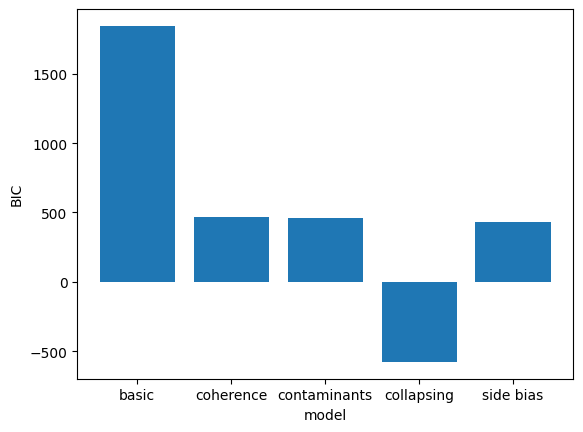

In [77]:
# let's turn it into a function that spits out the BIC for any fitted PyDDM object
def compute_bic(m):
    LLH = -m.fitresult.value() # value is the loss function which is negative LLH
    SampleSize = m.fitresult.properties['samplesize']
    nParams = m.fitresult.properties['nparams']

    return nParams * np.log(SampleSize) - 2 * LLH

# compute BIC for all models
all_models = [m_basic, m_coh, m_contaminant, m_collapsing, m_bias]
model_labels = ['basic','coherence','contaminants', 'collapsing','side bias']
all_BIC = [compute_bic(m) for m in all_models]

# plot as histogram
nModels = len(all_models)
plt.bar(np.arange(nModels), all_BIC);
plt.xticks(np.arange(nModels),model_labels);
plt.ylabel('BIC');
plt.xlabel('model');

**What do you conclude?**

The data are best explained by a model where drift depends on stimulus coherence and the decision bounds collapse over time (an urgency signal). The plain DDM is clearly inadequate, coherence is essential, and the strongest evidence is for additional time-dependent (collapsing) boundaries rather than for large contaminant or side-bias effects.